In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)  
old_shape = train_X.shape
print("old shape ", old_shape)
old_test_X = test_X.copy()  
train_X, test_X = prepare_for_neural_network(train_X, test_X)

# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

old shape  (10000, 32, 32, 3)


Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:

прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам
Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3], [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]]
numeric grad array is 
 [[ 1.61599406  0.          2.76252524]
 [ 0.         -0.5060347  -0.94302519]]
Gradient check passed!


In [19]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
numeric grad array is 
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
Gradient check passed!
CHECK GRADIENT
x is 
 [[-1.97365551e-03  6.80635002e-04  5.55869402e-05  5.41565103e-04]
 [ 1.83213048e-04 -5.59157557e-04  8.94307167e-04  1.98126611e-04]
 [-1.28938649e-03  1.30851716e-03 -1.43047956e-03  9.00929234e-04]]
analytic grad is 
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
numeric grad array is 
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
Gradient check passed!
CHECK GRADIENT
x is 
 [[-1.33418835e-03  2.29823155e-04  1.28956322e-03

In [20]:
# TODO: In model.py, implement compute_loss_and_gradients function
batch_size = 2
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:batch_size], train_y[:batch_size])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:batch_size], train_y[:batch_size])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[ 5.55132245e-04 -8.29725676e-04 -9.95647818e-04]
 [ 7.71607110e-04  8.55758768e-04 -1.27373828e-03]
 [-1.23679768e-03 -4.45049694e-04 -7.11304833e-04]
 ...
 [-1.27559794e-03 -5.69992050e-04  4.02575187e-04]
 [ 2.28669670e-04  1.30825243e-03  7.03814008e-06]
 [-1.76402810e-04 -1.57398266e-03 -8.06722910e-04]]
analytic grad is 
 [[ 2.10787160e-05  0.00000000e+00 -4.47056165e-05]
 [ 2.51157965e-05  0.00000000e+00 -9.99876323e-06]
 [ 7.14281875e-05  0.00000000e+00  8.78028877e-05]
 ...
 [-1.96137432e-04  0.00000000e+00 -1.67966637e-04]
 [-1.75261159e-04  0.00000000e+00 -1.05706581e-04]
 [-1.39601392e-04  0.00000000e+00 -5.89752946e-06]]
numeric grad array is 
 [[ 2.10787388e-05  0.00000000e+00 -4.47056170e-05]
 [ 2.51157761e-05  0.00000000e+00 -9.99875738e-06]
 [ 7.14281967e-05  0.00000000e+00  8.78028317e-05]
 ...
 [-1.96137417e-04  0.00000000e+00 -1.67966618e-04]
 [-1.75261183e-04  0.00000000e+00 -1.05706555e-04]
 [-1.39601397e-04  0.00000

True

In [21]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[-9.88162631e-04 -5.62436018e-05 -1.06671111e-03]
 [ 7.69188816e-04  4.08942767e-04  5.49801863e-04]
 [ 1.13086936e-03 -3.37809772e-04  1.07450757e-03]
 ...
 [-4.79073444e-04  3.42822914e-04 -1.04962798e-04]
 [ 1.54995685e-03 -3.56086006e-04  4.46385075e-04]
 [ 1.08696651e-03  6.55927424e-04  5.42182697e-04]]
analytic grad is 
 [[-0.01976325 -0.00123181 -0.02137282]
 [ 0.01538378  0.00813634  0.01095005]
 [ 0.02261739 -0.00664902  0.02135936]
 ...
 [-0.00958147  0.00670568 -0.00174011]
 [ 0.03099914 -0.00716936  0.00924862]
 [ 0.02173933  0.01323425  0.01109928]]
numeric grad array is 
 [[-0.01976325 -0.00123181 -0.02137282]
 [ 0.01538378  0.00813634  0.01095005]
 [ 0.02261739 -0.00664902  0.02135936]
 ...
 [-0.00958147  0.00670568 -0.00174011]
 [ 0.03099914 -0.00716936  0.00924862]
 [ 0.02173933  0.01323425  0.01109928]]
Gradient check passed!
Checking gradient for B1
CHECK GRADIENT
x is 
 [[-0.00050679  0.00011694  0.0004614 ]]
analytic

True

In [22]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

**Допишем код для процесса тренировки**


Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [23]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), num_epochs =20, batch_size=20, learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

X shape is
 (9000, 3072)
y shape is
 (9000,)
Epoch: 1, Loss: 35.675394, Train accuracy: 0.367111, val accuracy: 0.366000
Epoch: 2, Loss: 30.349073, Train accuracy: 0.561444, val accuracy: 0.552000
Epoch: 3, Loss: 23.660485, Train accuracy: 0.568778, val accuracy: 0.564000
Epoch: 4, Loss: 31.522042, Train accuracy: 0.616444, val accuracy: 0.597000
Epoch: 5, Loss: 19.279987, Train accuracy: 0.694222, val accuracy: 0.661000
Epoch: 6, Loss: 12.845285, Train accuracy: 0.704333, val accuracy: 0.670000
Epoch: 7, Loss: 14.159372, Train accuracy: 0.719222, val accuracy: 0.673000
Epoch: 8, Loss: 9.413003, Train accuracy: 0.751222, val accuracy: 0.681000
Epoch: 9, Loss: 17.753308, Train accuracy: 0.746667, val accuracy: 0.678000
Epoch: 10, Loss: 8.764459, Train accuracy: 0.779222, val accuracy: 0.693000
Epoch: 11, Loss: 26.346833, Train accuracy: 0.760889, val accuracy: 0.693000
Epoch: 12, Loss: 24.211047, Train accuracy: 0.748444, val accuracy: 0.660000
Epoch: 13, Loss: 15.083035, Train accuracy

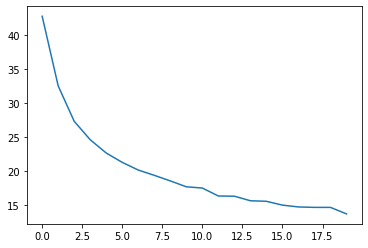

In [24]:
plt.plot(loss_history)
# plt.plot(train_history)
# plt.plot(val_history)

test x is  (1000, 3072)
test pred is 
 [2 1 3 9 2 5 0 1 7 2]
test_y  is 
 [2 1 3 0 2 5 0 1 7 1]


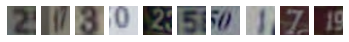

Neural network classifier test set accuracy: 67.600000


In [25]:
# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)


number = 10
print("test x is ", test_X.shape)
test_pred = model.predict(test_X[:number])
print("test pred is \n", test_pred)
print("test_y  is \n", test_y[:number])
plot_index = 1
for class_index in range(number):
        plt.subplot(1, number, plot_index)
        
        image = old_test_X[class_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

plt.show()
# print("test pred is \n", test_pred[:number])

test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

# Улучшаем процесс тренировки
Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

**Уменьшение скорости обучения (learning rate decay)**
Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data).

В нашем случае N будет равным 1.

In [12]:
# # TODO Implement learning rate decay inside Trainer.fit method
# # Decay should happen once per epoch

# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
# dataset = Dataset(train_X, train_y, val_X, val_y)
# trainer = Trainer(model, dataset, SGD(),learning_rate = 1e-2, learning_rate_decay=0.99)

# initial_learning_rate = trainer.learning_rate
# loss_history, train_history, val_history = trainer.fit()

# assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
# assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости. (Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

velocity = momentum * velocity - learning_rate * gradient 

w = w + velocity

momentum здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:

http://cs231n.github.io/neural-networks-3/#sgd

https://distill.pub/2017/momentum/

In [5]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

X shape is
 (9000, 3072)
y shape is
 (9000,)
Epoch: 1, Loss: 29.508575, Train accuracy: 0.362889, val accuracy: 0.357000
Epoch: 2, Loss: 24.935992, Train accuracy: 0.575000, val accuracy: 0.582000
Epoch: 3, Loss: 33.527397, Train accuracy: 0.592667, val accuracy: 0.563000
Epoch: 4, Loss: 29.925105, Train accuracy: 0.647333, val accuracy: 0.627000


learning rate is  0.008179069375972308


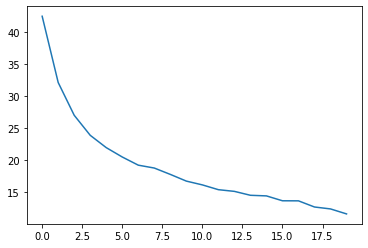

test x shape is  (1000, 3072)
test pred is 
 [2 1 3 3 2 5 9 1 7 1]
test_y  is 
 [2 1 3 0 2 5 0 1 7 1]


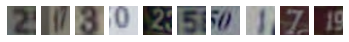

Neural network classifier test set accuracy: 70.600000


In [6]:
print("learning rate is ", trainer.learning_rate)
# print("initial learning rate is ", initial_learning_rate)
plt.plot(loss_history)
plt.show()

number = 10
print("test x shape is ", test_X.shape)
test_pred = model.predict(test_X[:number])
print("test pred is \n", test_pred)
print("test_y  is \n", test_y[:number])

for i in range(number):
        plt.subplot(1, number, i+1)        
        image = old_test_X[i].astype(np.uint8)
        plt.imshow(image)
        plt.axis('off')

plt.show()
# print("test pred is \n", test_pred[:number])

test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

# Ну что, давайте уже тренировать сеть!
Последний тест - переобучимся (overfit) на маленьком наборе данных
Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе.

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
# data_size = 15
# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
# dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)

# # You should expect this to reach 1.0 training accuracy 
# loss_history, train_history, val_history = trainer.fit()
# #############################################################################

# print("learning rate is ", trainer.learning_rate)
# # print("initial learning rate is ", initial_learning_rate)
# plt.plot(loss_history)
# plt.show()

# number = 10
# print("test x shape is ", test_X.shape)
# test_pred = model.predict(test_X[:number])
# print("test pred is \n", test_pred)
# print("test_y  is \n", test_y[:number])

# for i in range(number):
#         plt.subplot(1, number, i+1)        
#         image = old_test_X[i].astype(np.uint8)
#         plt.imshow(image)
#         plt.axis('off')

# plt.show()
# # print("test pred is \n", test_pred[:number])

# test_pred = model.predict(test_X)
# test_accuracy = multiclass_accuracy(test_pred, test_y)*100
# print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать.

Добейтесь точности лучше 60% на validation set.

In [19]:
print("old  shape ", old_shape)
reshaped_val_X = val_X.reshape (val_X.shape[0], 32, 32, 3)
print("val shape ", reshaped_val_X.shape)

old  shape  (10000, 32, 32, 3)
val shape  (1000, 32, 32, 3)


resh val x shape is  (1000, 32, 32, 3)
X shape is
 (9000, 3072)
y shape is
 (9000,)
Epoch: 1, Loss: 31.591419, Train accuracy: 0.347444, val accuracy: 0.357000
Epoch: 2, Loss: 32.544192, Train accuracy: 0.560222, val accuracy: 0.565000
Epoch: 3, Loss: 14.823781, Train accuracy: 0.637000, val accuracy: 0.623000
Epoch: 4, Loss: 25.851587, Train accuracy: 0.662222, val accuracy: 0.642000
Epoch: 5, Loss: 30.978400, Train accuracy: 0.696333, val accuracy: 0.649000
Epoch: 6, Loss: 33.269603, Train accuracy: 0.678556, val accuracy: 0.658000
Epoch: 7, Loss: 22.494949, Train accuracy: 0.754111, val accuracy: 0.690000
Epoch: 8, Loss: 12.312143, Train accuracy: 0.690556, val accuracy: 0.630000
Epoch: 9, Loss: 17.944703, Train accuracy: 0.749778, val accuracy: 0.687000
Epoch: 10, Loss: 15.654944, Train accuracy: 0.776111, val accuracy: 0.693000
Epoch: 11, Loss: 17.826699, Train accuracy: 0.732889, val accuracy: 0.639000
Epoch: 12, Loss: 13.681654, Train accuracy: 0.781444, val accuracy: 0.690000
E

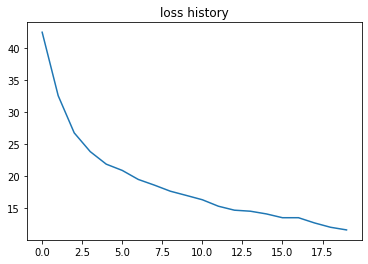

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


validation x shape is  (1000, 3072)
val pred is 
 [2 9 8 4 6 5 3 3 3 7]
val_y  is 
 [2 9 8 4 6 5 3 3 3 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


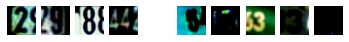

Neural network classifier validation set accuracy: 69.700000
best validation accuracy achieved: 69.700000


In [53]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-5
learning_rate_decay = 0.999
hidden_layer_size = 150
num_epochs = 20
batch_size = 20
resh_val_X = val_X.reshape(val_X.shape[0], 32, 32, 3)
np.random.seed(7777)
print("resh val x shape is ", resh_val_X.shape)

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),batch_size =batch_size, num_epochs=num_epochs,  learning_rate=learning_rates, learning_rate_decay=learning_rate_decay)
# # You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

print("learning rate is ", trainer.learning_rate)

plt.title("loss history")
plt.plot(loss_history)
plt.show()

number = 10
print("validation x shape is ", val_X.shape)
validation_pred = model.predict(val_X[:number])
print("val pred is \n", validation_pred)
print("val_y  is \n", val_y[:number])

for i in range(number):
        plt.subplot(1, number, i+1)        
        image = (resh_val_X[i])
        image = image/np.amax(image) # if float
        plt.imshow(image)
        plt.axis('off')

plt.show()

val_pred = model.predict(val_X)
validation_accuracy = multiclass_accuracy(val_pred, val_y)*100
print('Neural network classifier validation set accuracy: %f' % (validation_accuracy, ))

best_val_accuracy = validation_accuracy
# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above


print('best validation accuracy achieved: %f' % best_val_accuracy)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

Neural net test set accuracy: 0.716000


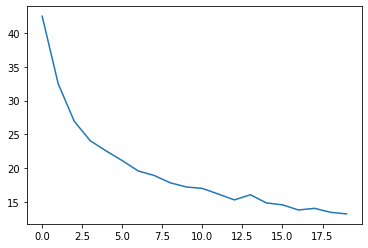

test x shape is  (1000, 3072)
test pred is 
 [2 1 3 1 2 5 0 1 7 1]
test_y  is 
 [2 1 3 0 2 5 0 1 7 1]


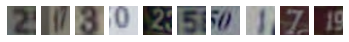

Neural network classifier test set accuracy: 71.600000


In [85]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

plt.plot(loss_history)
plt.show()

number = 10
print("test x shape is ", test_X.shape)
test_pred = model.predict(test_X[:number])
print("test pred is \n", test_pred)
print("test_y  is \n", test_y[:number])

for i in range(number):
        plt.subplot(1, number, i+1)        
        image = old_test_X[i].astype(np.uint8)
        plt.imshow(image)
        plt.axis('off')

plt.show()
# print("test pred is \n", test_pred[:number])

test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

In [14]:

X = np.array([[1,-2,3],
              [-1, 2, 0.1]])

X.fill(0)
if X is None:
    print("X is none")
# X[1,2]= 1
# all_zeros = not np.any(X)
# Y = np.array([[1,3,3],
#               [-1, 2, 0.1]])
# # print(X*Y)

# # lst = [a, 4,3]
# mapa = {'X': X, 'Y': Y}
# # print("loss is ", loss)

# loss_lst = [np.sum(param**2) for param in mapa.values()]
# loss =  sum(loss_lst)

np.random.seed(0)
a =np.random.rand(3,2)
b = a
# b[0] = 44
# print (a)
print("X is \n", X)
# print(all_zeros)
# print("mapa is \n", mapa)
# # print("reg loss params is\n", reg_loss_params)
# print("loss lst\n", loss_lst)
# print("loss ", loss)

X is 
 [[0. 0. 0.]
 [0. 0. 0.]]
